Notebook Link: https://colab.research.google.com/drive/1k6agsnHHkWKQm0mCqOuWS3OAZAr56pBf?usp=sharing

Cruz ID: spandey7

# **Imports**

In [1]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 30.0 MB/s 
     |████████████████████████████████| 115 kB 70.5 MB/s 
     |████████████████████████████████| 95 kB 6.2 MB/s 
     |████████████████████████████████| 212 kB 70.2 MB/s 
     |████████████████████████████████| 163 kB 67.2 MB/s 
     |████████████████████████████████| 127 kB 68.8 MB/s 
     |████████████████████████████████| 115 kB 56.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


In [2]:
import torch                      #Using PyTorch to define, train and evaluate model
import torch.nn as nn             
import torch.optim as optim       #For using the optimizer function
import math
from matplotlib import pyplot as plt
import datasets
from itertools import chain
from tqdm import tqdm             #Shows progress bars during training and evaluation
from datasets import load_dataset #Using huggingface to load and map the dataset

In [3]:
"""
    We set a device variable that we will use later 
    in functions to ensure that computation takes place
    on the GPU if possible and we set a seed value 
    so that we can reproduce the results whenever we need to.
"""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

# **Data Extraction and Tokenization**

In [4]:
ptb = load_dataset('ptb_text_only')
print(ptb)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/42068 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3761 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3370 [00:00<?, ? examples/s]

Dataset ptb_text_only downloaded and prepared to /root/.cache/huggingface/datasets/ptb_text_only/penn_treebank/1.1.0/8d1b97746fb9765d140e569ec5ddd35e20af4d37761f5e1bf357ea0b081f2c1f. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence'],
        num_rows: 42068
    })
    test: Dataset({
        features: ['sentence'],
        num_rows: 3761
    })
    validation: Dataset({
        features: ['sentence'],
        num_rows: 3370
    })
})


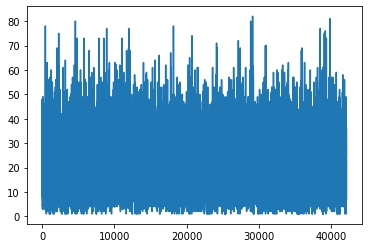

In [25]:
sen_len = [len(i.split(" ")) for i in ptb["train"]["sentence"]]
plt.plot(sen_len)
plt.show()

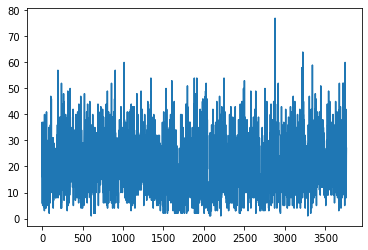

In [26]:
sen_len = [len(i.split(" ")) for i in ptb["test"]["sentence"]]
plt.plot(sen_len)
plt.show()

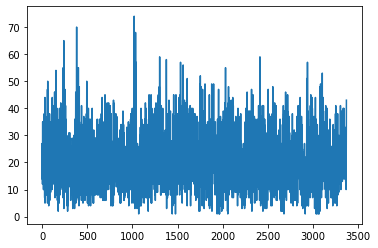

In [27]:
sen_len = [len(i.split(" ")) for i in ptb["validation"]["sentence"]]
plt.plot(sen_len)
plt.show()

In [5]:
def tokenize_text(text): 
  """
    Using split function to tokenize words in the dataset 
    for word based language model
  """
  a = []
  a.append(text.split())
  flatten_list = list(chain.from_iterable(a)) #Flattening the 2D array to 1D
  return flatten_list
tokenize_data = lambda example, tokenize_text: {'tokens': tokenize_text(example['sentence'])}

In [6]:
"""
We use the map function from the datasets library to apply the tokenize_data function on each example. 
Map will need to pass the example along with the tokenizer to tokenize_data so we pass the tokenizer in fn_kwargs as well.
"""
tokenized_dataset = ptb.map(tokenize_data, remove_columns=['sentence'], fn_kwargs={'tokenize_text': tokenize_text})

  0%|          | 0/42068 [00:00<?, ?ex/s]

  0%|          | 0/3761 [00:00<?, ?ex/s]

  0%|          | 0/3370 [00:00<?, ?ex/s]

In [7]:
#Constructing Vocabulary
vocab = []
for i in ptb['train']['sentence']:
  vocab+= i.split()
for i in ptb['test']['sentence']:
  vocab+= i.split()
for i in ptb['validation']['sentence']:
  vocab+= i.split()

In [8]:
#Adding <start>, <eos> tokens in the vocabulary which will be used as identifiers for sequence start and end
vocab.insert(0, '<start>')           
vocab.insert(1, '<eos>')
vocab = set(vocab)
print(len(vocab))
vocab = list(vocab)
vocab_dict = {k: v for v, k in enumerate(vocab)}

10001


# **Data Loader**

In [9]:
def get_data(dataset, vocab, batch_size):                      #DataLoader Function
  """
    Dataloader is a function that provides a way to iterate over batches of a dataset. 
    All the examples in a batch are processed simultaneously.
  """
  text = []                                                    #Merge everything into 1 list                                               
  for i in dataset:
    if i['tokens']:                                            #If i is not empty                                  
      tokens = i['tokens'].append('<eos>')                     #Append <eos> after every sequence         
      tokens = [vocab_dict[token] for token in i['tokens']]    #Create indices from tokens
      text.extend(tokens)                                      #Append tokens in the list                               
  text = torch.LongTensor(text)                                #Converting list to a 1D tensor                             
  num_batches = text.shape[0] // batch_size 
  text = text[:num_batches * batch_size]         #We require the first num_batches * batch_size elements
  text = text.view(batch_size, num_batches)      #Reshaping the 1D tensor to a 2D tensor of batch_size rows and num_batches columns    
  return text
batch_size = 128
train_data = get_data(tokenized_dataset['train'], vocab, batch_size) #train_data[:, i] is the batch of next tokens for train_data[:, i - 1]
valid_data = get_data(tokenized_dataset['validation'], vocab, batch_size)
test_data = get_data(tokenized_dataset['test'], vocab, batch_size)

# **Model Class**

In [10]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, 
                tie_weights):
      
        """
           LSTM takes as input a tensor of shape [N, L, E] where:
           N is the batch_size
           L is the sequence length 
           E is the length of each element in the sequence (embedding length)
        """
                
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)    #Map each word (given as an index) into a vector of E dimensions that further layers can learn from
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)                     #As a form of regularization, we use a dropout layer before each of the embedding, LSTM, and output layers.
        self.fc = nn.Linear(hidden_dim, vocab_size)   
        if tie_weights:                                             #Makes the embedding layer share weights with the output layer
            assert embedding_dim == hidden_dim, 'cannot tie, check dims'
            self.embedding.weight = self.fc.weight
        self.init_weights()

    def forward(self, src, hidden):             
        embedding = self.dropout(self.embedding(src))
        output, hidden = self.lstm(embedding, hidden)          
        output = self.dropout(output) 
        prediction = self.fc(output)
        return prediction, hidden
    def init_weights(self):                          #Initialize the embedding weights uniformly in the range [-0.1, 0.1] 
        init_range_emb = 0.1                         #and all other layers uniformly in the range [-1/sqrt(H), 1/sqrt(H)]
        init_range_other = 1/math.sqrt(self.hidden_dim)
        self.embedding.weight.data.uniform_(-init_range_emb, init_range_emb)
        self.fc.weight.data.uniform_(-init_range_other, init_range_other)
        self.fc.bias.data.zero_()
        for i in range(self.num_layers):             #Iterating through layers to initialize its hidden to hidden and hidden to next layer weights
            self.lstm.all_weights[i][0] = torch.FloatTensor(self.embedding_dim,
                    self.hidden_dim).uniform_(-init_range_other, init_range_other) 
            self.lstm.all_weights[i][1] = torch.FloatTensor(self.hidden_dim, 
                    self.hidden_dim).uniform_(-init_range_other, init_range_other) 

    def init_hidden(self, batch_size, device):       #Setting the hidden and cell state to zero
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return hidden, cell
    def detach_hidden(self, hidden):                 #Tells PyTorch that hidden states due to different sequences are independent
        hidden, cell = hidden
        hidden = hidden.detach()
        cell = cell.detach()
        return hidden, cell

In [11]:
#Initialising hyperparameters
vocab_size = len(vocab)
embedding_dim = 1024  #Same dimensions for weight tying             
hidden_dim = 1024     #Same dimensions for weight tying              
num_layers = 2                   
dropout_rate = 0.50              
tie_weights = True                  
lr = 1e-3   

In [12]:
#Initializing model
model = LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, tie_weights).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)   
criterion = nn.CrossEntropyLoss()
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 27,044,625 trainable parameters


In [13]:
def get_batch(data, seq_len, num_batches, idx):
  """
      using a fixed backpropagation through time window 
      to deal with the problem of sequences with unequal lengths.
      The function given the index of the first batch of tokens
      in the batch, returns the corresponding batch of sequences
  """
  src = data[:, idx:idx+seq_len]                   
  target = data[:, idx+1:idx+seq_len+1]  #Target is src shifted by one batch           
  return src, target

# **Training Loop**

In [14]:
def train(model, data, optimizer, criterion, batch_size, seq_len, clip, device):  
  epoch_loss = 0
  model.train()
  #Drop all batches that are not a multiple of sequence length
  num_batches = data.shape[-1]
  data = data[:, :num_batches - (num_batches -1) % seq_len] #Breaking down data into batches of sequence length
  num_batches = data.shape[-1]
  hidden = model.init_hidden(batch_size, device)
  
  for idx in tqdm(range(0, num_batches - 1, seq_len), desc='Training: ',leave=False):  # The last batch can't be a src
    """
      In the loop, we consider the dataset at indices [0, seq_len, 2*seq_len,..]
      each of which will be sent to get_batch()
      to return the corresponding sequence of batches for the input (src) and the labels (trg). 
      Both have dimensions [batch size, seq_len].
    """
    optimizer.zero_grad()                     #Making the gradient 0 due to the previous batch
    hidden = model.detach_hidden(hidden)      #Detaching the last batch's hidden state
    src, target = get_batch(data, seq_len, num_batches, idx)
    src, target = src.to(device), target.to(device)
    batch_size = src.shape[0]
    prediction, hidden = model(src, hidden)                     #Model Output ([batch size, seq_len, vocab size])           
    prediction = prediction.reshape(batch_size * seq_len, -1)   #Reshaping output into [batch_size*seq_len, vocab]
    target = target.reshape(-1)                                 #Flattening the target to [batch size * seq_len]
    loss = criterion(prediction, target)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)    #Computing Gradient and applying clip to sidestep exploding gradient
    optimizer.step()                        #Updating the weights
    epoch_loss += loss.item() * seq_len     #Loss.item() has the total loss divided by the batch_size and sequence_length, we multiply by seq_len so we can calculate the average loss per sequence (instead of per token)
  return epoch_loss / num_batches

In [15]:
def evaluate(model, data, criterion, batch_size, seq_len, device):
  """
    Similar to the training loop except that 
    we no longer need to backprop or keep track of gradients
  """
  epoch_loss = 0
  model.eval()
  num_batches = data.shape[-1]
  data = data[:, :num_batches - (num_batches -1) % seq_len]
  num_batches = data.shape[-1]
  hidden = model.init_hidden(batch_size, device)
  with torch.no_grad():
    for idx in range(0, num_batches - 1, seq_len):
      hidden = model.detach_hidden(hidden)
      src, target = get_batch(data, seq_len, num_batches, idx)
      src, target = src.to(device), target.to(device)
      batch_size= src.shape[0]
      prediction, hidden = model(src, hidden)
      prediction = prediction.reshape(batch_size * seq_len, -1)
      target = target.reshape(-1)
      loss = criterion(prediction, target)
      epoch_loss += loss.item() * seq_len
  return epoch_loss / num_batches

In [16]:
n_epochs = 50
seq_len = 50
clip = 0.25
saved = True
loss_train = []
loss_valid = []
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0)
#We use ReduceLROnPlateu to reduce the learning rate by a factor of 2 after every epoch with no improvement
best_valid_loss = float('inf')

for epoch in range(n_epochs):
    train_loss = train(model, train_data, optimizer, criterion, 
                batch_size, seq_len, clip, device)
    valid_loss = evaluate(model, valid_data, criterion, batch_size, 
                seq_len, device)
    loss_train.append(train_loss)
    loss_valid.append(valid_loss)
    
    lr_scheduler.step(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-lstm_lm.pt')
    print("Epoch:", epoch)
    print(f'\tTrain Perplexity: {math.exp(train_loss):.3f}')
    print(f'\tValid Perplexity: {math.exp(valid_loss):.3f}')

Epoch: 0
	Train Perplexity: 768.119
	Valid Perplexity: 788.299


Epoch: 1
	Train Perplexity: 445.730
	Valid Perplexity: 327.278


Epoch: 2
	Train Perplexity: 291.325
	Valid Perplexity: 248.397


Epoch: 3
	Train Perplexity: 227.308
	Valid Perplexity: 210.450


Epoch: 4
	Train Perplexity: 191.493
	Valid Perplexity: 187.575


Epoch: 5
	Train Perplexity: 166.860
	Valid Perplexity: 171.471


Epoch: 6
	Train Perplexity: 149.447
	Valid Perplexity: 158.842


Epoch: 7
	Train Perplexity: 135.516
	Valid Perplexity: 150.032


Epoch: 8
	Train Perplexity: 124.246
	Valid Perplexity: 145.060


Epoch: 9
	Train Perplexity: 115.272
	Valid Perplexity: 136.955


Epoch: 10
	Train Perplexity: 107.250
	Valid Perplexity: 131.214


Epoch: 11
	Train Perplexity: 100.545
	Valid Perplexity: 127.317


Epoch: 12
	Train Perplexity: 94.848
	Valid Perplexity: 124.931


Epoch: 13
	Train Perplexity: 89.983
	Valid Perplexity: 121.808


Epoch: 14
	Train Perplexity: 85.249
	Valid Perplexity: 118.632


Epoch: 15
	Train Perplexity: 81.126
	Valid Perplexity: 116.444


Epoch: 16
	Train Perplexity: 77.429
	Valid Perplexity: 115.731


Epoch: 17
	Train Perplexity: 74.190
	Valid Perplexity: 114.632


Epoch: 18
	Train Perplexity: 71.497
	Valid Perplexity: 112.571


Epoch: 19
	Train Perplexity: 68.431
	Valid Perplexity: 110.882


Epoch: 20
	Train Perplexity: 65.687
	Valid Perplexity: 109.633


Epoch: 21
	Train Perplexity: 65.184
	Valid Perplexity: 109.050


Epoch: 22
	Train Perplexity: 62.526
	Valid Perplexity: 111.684


Epoch: 23
	Train Perplexity: 59.585
	Valid Perplexity: 106.913


Epoch: 24
	Train Perplexity: 56.507
	Valid Perplexity: 106.624


Epoch: 25
	Train Perplexity: 55.138
	Valid Perplexity: 106.821


Epoch: 26
	Train Perplexity: 53.850
	Valid Perplexity: 106.144


Epoch: 27
	Train Perplexity: 53.033
	Valid Perplexity: 105.645


Epoch: 28
	Train Perplexity: 52.289
	Valid Perplexity: 104.973


Epoch: 29
	Train Perplexity: 51.715
	Valid Perplexity: 104.762


Epoch: 30
	Train Perplexity: 51.164
	Valid Perplexity: 104.473


Epoch: 31
	Train Perplexity: 50.526
	Valid Perplexity: 104.349


Epoch: 32
	Train Perplexity: 49.998
	Valid Perplexity: 104.181


Epoch: 33
	Train Perplexity: 49.417
	Valid Perplexity: 104.352


Epoch: 34
	Train Perplexity: 48.789
	Valid Perplexity: 103.244


Epoch: 35
	Train Perplexity: 48.533
	Valid Perplexity: 103.436


Epoch: 36
	Train Perplexity: 48.411
	Valid Perplexity: 103.165


Epoch: 37
	Train Perplexity: 48.351
	Valid Perplexity: 103.099


Epoch: 38
	Train Perplexity: 48.228
	Valid Perplexity: 103.243


Epoch: 39
	Train Perplexity: 48.404
	Valid Perplexity: 103.237


Epoch: 40
	Train Perplexity: 48.882
	Valid Perplexity: 103.315


Epoch: 41
	Train Perplexity: 49.055
	Valid Perplexity: 103.352


Epoch: 42
	Train Perplexity: 49.199
	Valid Perplexity: 103.395


Epoch: 43
	Train Perplexity: 49.304
	Valid Perplexity: 103.419


Epoch: 44
	Train Perplexity: 49.286
	Valid Perplexity: 103.427


Epoch: 45
	Train Perplexity: 49.353
	Valid Perplexity: 103.433


Epoch: 46
	Train Perplexity: 49.352
	Valid Perplexity: 103.436


Epoch: 47
	Train Perplexity: 49.350
	Valid Perplexity: 103.437


Epoch: 48
	Train Perplexity: 49.384
	Valid Perplexity: 103.437


Epoch: 49
	Train Perplexity: 49.383
	Valid Perplexity: 103.438


# **Evaluation**

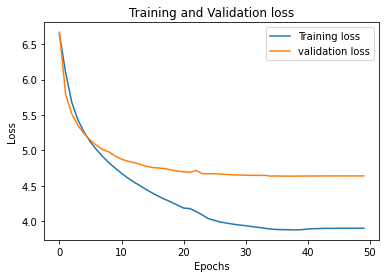

In [23]:
import matplotlib.pyplot as plt
epochs = []
for i in range(n_epochs):
  epochs.append(i)
plt.plot(epochs, loss_train, label='Training loss')
plt.plot(epochs, loss_valid, label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

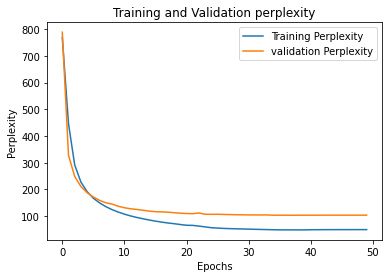

In [22]:
train_ppl = []
val_ppl = []
for i in loss_train:
    train_ppl.append(math.exp(i))
for i in loss_valid:
    val_ppl.append(math.exp(i))
plt.plot(epochs, train_ppl, label='Training Perplexity')
plt.plot(epochs, val_ppl, label='validation Perplexity')
plt.title('Training and Validation perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

In [24]:
model.load_state_dict(torch.load('best-val-lstm_lm.pt',  map_location=device))
test_loss = evaluate(model, test_data, criterion, batch_size, seq_len, device)
print(f'Test Perplexity: {math.exp(test_loss):.3f}')

Test Perplexity: 95.752
